In [1]:
# Import basic libraries to handle data and build the model
import zipfile
import os

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split

In [2]:
!git clone https://github.com/Prashant-AV/Qualcomm-DL-Hackathon.git

Cloning into 'Qualcomm-DL-Hackathon'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 10 (delta 1), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (10/10), 30.68 MiB | 20.78 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [3]:
# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
os.chdir("/content/Qualcomm-DL-Hackathon/train")
extract_dir = "/content/Qualcomm-DL-Hackathon/train/"
os.makedirs(extract_dir, exist_ok=True)

# Open and extract the zip file
with zipfile.ZipFile("images part-1.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
with zipfile.ZipFile("images part-2.zip", 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print(f"Contents extracted to {extract_dir}")

Contents extracted to /content/Qualcomm-DL-Hackathon/train/


In [5]:
os.rename('/content/Qualcomm-DL-Hackathon/train/images part-1', '/content/Qualcomm-DL-Hackathon/train/images')

In [6]:
import shutil
for x in os.listdir('/content/Qualcomm-DL-Hackathon/train/images part-2'):
  source_path = os.path.join('/content/Qualcomm-DL-Hackathon/train/images part-2', x)
  shutil.move(source_path, '/content/Qualcomm-DL-Hackathon/train/images/')

In [7]:
#shutil.rmtree('/content/Qualcomm-DL-Hackathon/train/images')
shutil.rmtree('/content/Qualcomm-DL-Hackathon/train/images part-2')

In [8]:
from PIL import Image
os.getcwd()

'/content/Qualcomm-DL-Hackathon/train'

In [9]:
#reading images to check size
count = 0
for x in os.listdir('/content/Qualcomm-DL-Hackathon/train/images/'):
  img = Image.open('/content/Qualcomm-DL-Hackathon/train/images/'+x)
  count+=1
count, img.size

(2352, (224, 224))

In [10]:
!pip install efficientnet_pytorch

  Preparing metadata (setup.py) ... done
  Created wheel for efficientnet_pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16424 sha256=18012070952a4ac111b6fda11fba0d1cd88a50a0877b33e307fcb2aefe054fa7
  Stored in directory: /root/.cache/pip/wheels/03/3f/e9/911b1bc46869644912bda90a56bcf7b960f20b5187feea3baf
Successfully built efficientnet_pytorch


In [11]:
import numpy as np
import pandas as pd
from efficientnet_pytorch import EfficientNet

In [12]:
# creating transforms to resize and normalize te features based on imagenet standards
t_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet mean/std
])


In [13]:
os.chdir("/content/Qualcomm-DL-Hackathon/train/")

In [14]:
# creating customdataset for transforming images to tensors and returning image tensors and labels
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None, train=True):
        self.data = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform
        self.train = train

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        if self.transform:
            image = self.transform(image)

        if self.train:
            label = self.data.iloc[idx, 1]
            return image, label
        else:
            return image

In [15]:
# creating Datasets for training and testing
train_dataset = CustomDataset(csv_file='/content/Qualcomm-DL-Hackathon/train/train.csv', root_dir='images', transform=t_transforms)
test_dataset = CustomDataset(csv_file='/content/Qualcomm-DL-Hackathon/test.csv', root_dir='images', transform=t_transforms, train=False)


In [16]:
# Split training data into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

In [17]:
train_size, val_size

(1316, 330)

In [18]:
# creating data loaders in the batches of size 32
batch_size = 32
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
# choosing Efficient net architecture as it is best for image classification tasks
model = EfficientNet.from_pretrained('efficientnet-b0')  # choosing model B0 as it is smallest and least computational.
num_ftrs = model._fc.in_features
print(num_ftrs)
model._fc = nn.Linear(num_ftrs, 2)  # 2 classes: emergency and non-emergency
model = model.to(device)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b0-355c32eb.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b0-355c32eb.pth
100%|██████████| 20.4M/20.4M [00:00<00:00, 246MB/s]


Loaded pretrained weights for efficientnet-b0
1280


In [20]:
# Defining the loss function and optimizer
criterion = nn.CrossEntropyLoss()  # for classification
optimizer = optim.Adam(model.parameters(), lr=0.001) #optimiser with learning rate 0.001

In [21]:
#training the model on internally split train data
num_epochs = 5
best_accuracy = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%")

    if epoch_acc > best_accuracy:
        best_accuracy = epoch_acc

print(f'Best Validation Accuracy: {best_accuracy:.2f}%')

torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/5, Loss: 0.3371, Accuracy: 86.63%
Epoch 2/5, Loss: 0.1114, Accuracy: 96.12%
Epoch 3/5, Loss: 0.0653, Accuracy: 98.02%
Epoch 4/5, Loss: 0.1369, Accuracy: 95.06%
Epoch 5/5, Loss: 0.0762, Accuracy: 97.95%
Best Validation Accuracy: 98.02%


In [22]:
# importing necessary libraries for printing evaluation metrics
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

              precision    recall  f1-score   support

           0       0.96      0.88      0.92       182
           1       0.87      0.95      0.91       148

    accuracy                           0.91       330
   macro avg       0.91      0.92      0.91       330
weighted avg       0.92      0.91      0.91       330



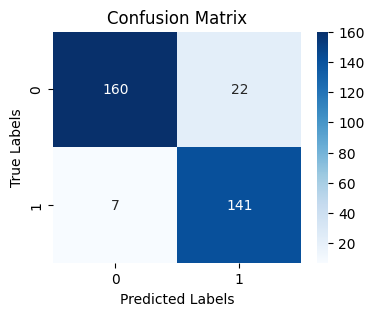

Validation Accuracy: 91.21%


In [23]:
#Evaluating model on internal test data val_dataset and printing evaluation metrics
model.eval()
val_labels = []
val_predictions = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)

        val_labels.extend(labels.cpu().numpy())  # Collect true labels
        val_predictions.extend(predicted.cpu().numpy())  # Collect predicted labels

# Generate the confusion matrix
cm = confusion_matrix(val_labels, val_predictions)
cr=classification_report(val_labels, val_predictions)

print(cr)

# Plot the confusion matrix using Seaborn heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# Print the test accuracy
val_accuracy = 100 * sum(np.array(val_labels) == np.array(val_predictions)) / len(val_labels)
print(f'Validation Accuracy: {val_accuracy:.2f}%')


In [24]:
# evaluating images in test.csv file and writing predictions
model.load_state_dict(torch.load('best_model.pth'))
model.eval()
predictions = []

with torch.no_grad():
    for images in test_loader:
        images = images.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        predictions.extend(predicted.cpu().numpy())

# Save predictions to CSV
test_data = pd.read_csv('/content/Qualcomm-DL-Hackathon/test.csv')
test_data['emergency_or_not'] = predictions
test_data.to_csv('/content/Qualcomm-DL-Hackathon/test_predictions.csv', index=False)
print('labels written to test_prediction.csv')

<ipython-input-24-8410d59754f6>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_model.pth'))


labels written to test_prediction.csv
